In [1]:
import os,glob,sys,joblib
import pandas as pd
import numpy as np
import nibabel as nb
from nilearn.masking import apply_mask,unmask
from collections import Counter
sys.path.append('/home/lxm/2_lxm/2024/2_gongji/scripts/5post_stats')
from model import Selection
from sklearn.model_selection import train_test_split,RepeatedKFold,StratifiedShuffleSplit
from scipy.stats import zscore
from matplotlib import pyplot as plt
from scipy.ndimage import distance_transform_edt, binary_dilation
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV,cross_val_predict
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error,explained_variance_score
from scipy.stats import pearsonr
from sklearn.linear_model import ElasticNet,Lasso,LinearRegression
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import pingouin as pg
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib as mpl
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"
mpl.rcParams['figure.dpi']= 300

In [2]:
# load img_data
tens_img_sham_pre_left = np.load('0data/tens_img_sham_pre_left.npy')
tens_img_sham_pre_right = np.load('0data/tens_img_sham_pre_right.npy')
tens_img_sham_post_left = np.load('0data/tens_img_sham_post_left.npy')
tens_img_sham_post_right = np.load('0data/tens_img_sham_post_right.npy')
tens_img_tens_pre_left = np.load('0data/tens_img_tens_pre_left.npy')
tens_img_tens_pre_right = np.load('0data/tens_img_tens_pre_right.npy')
tens_img_tens_post_left = np.load('0data/tens_img_tens_post_left.npy')
tens_img_tens_post_right = np.load('0data/tens_img_tens_post_right.npy')
# load behav_data
tens_behav_sham_pre_left = np.load('0data/tens_behav_sham_pre_left.npy')
tens_behav_sham_pre_right = np.load('0data/tens_behav_sham_pre_right.npy')
tens_behav_sham_post_left = np.load('0data/tens_behav_sham_post_left.npy')
tens_behav_sham_post_right = np.load('0data/tens_behav_sham_post_right.npy')
tens_behav_tens_pre_left = np.load('0data/tens_behav_tens_pre_left.npy')
tens_behav_tens_pre_right = np.load('0data/tens_behav_tens_pre_right.npy')
tens_behav_tens_post_left = np.load('0data/tens_behav_tens_post_left.npy')
tens_behav_tens_post_right = np.load('0data/tens_behav_tens_post_right.npy')


# con ANOVA

In [3]:
import pandas as pd
xi = tens_behav_sham_pre_left
yi = tens_behav_sham_pre_right
zi = tens_behav_sham_post_left
wi = tens_behav_sham_post_right
# 假设四个数组长度相同
n = len(xi)
assert len(yi)  == n
assert len(zi)  == n
assert len(wi) == n

# 生成被试 ID（可从 1 到 n，也可用 0 到 n-1 都行）
subjects = np.arange(1, n+1)

# 对于每个被试，需要创建 4 条记录：left-pre, right-pre, left-post, right-post
# 我们把它们拼接起来，形成一个一维向量
values = np.concatenate([
    xi,    # 对应 left × pre
    yi,   # 对应 right × pre
    zi,   # 对应 left × post
    wi   # 对应 right × post
])

# 对应的 condition 标记
condition = (['left']  * n) + (['right'] * n) + (['left']  * n) + (['right'] * n)

# 对应的 time 标记
time = (['pre']  * n) + (['pre']  * n) + (['post'] * n) + (['post'] * n)

# 对应的 subject 标记：每个被试在四个记录中都要出现
subject = list(subjects) * 4

# 构建 DataFrame
df = pd.DataFrame({
    'subject': subject,
    'condition': condition,
    'time': time,
    'value': values
})

import pingouin as pg

# 这里假设 df 已经如上构建：
# df.columns = ['subject', 'condition', 'time', 'value']

aov = pg.rm_anova(
    dv='value',                # 因变量列名
    within=['condition', 'time'], # 两个组内因子
    subject='subject',         # 被试 ID 列
    data=df,
    detailed=True              # 输出更详细结果（包括各效应的 η²、校正信息等）
)
print(aov)

             Source        SS  ddof1  ddof2        MS          F     p-unc  \
0         condition  9.948779      1     30  9.948779  23.822506  0.000033   
1              time  0.952878      1     30  0.952878   2.765012  0.106761   
2  condition * time  0.142936      1     30  0.142936   0.711936  0.405480   

   p-GG-corr       ng2  eps  
0   0.000033  0.057961  1.0  
1   0.106761  0.005858  1.0  
2   0.405480  0.000883  1.0  


/home/lxm/anaconda3/envs/test/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/home/lxm/anaconda3/envs/test/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)


In [4]:
posthoc = pg.pairwise_ttests(
    dv='value',
    within=['condition', 'time'],
    subject='subject',
    data=df,
    padjust='bonf'   # Bonferroni 校正
)

posthoc

/home/lxm/anaconda3/envs/test/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,condition,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,condition,-,left,right,True,True,-4.880830,30.0,two-sided,0.000033,NaN,NaN,712.896,-0.508303
1,time,-,post,pre,True,True,1.662833,30.0,two-sided,0.106761,NaN,NaN,0.656,0.158509
2,condition * time,left,post,pre,True,True,1.834119,30.0,two-sided,0.076573,0.153146,bonf,0.846,0.196817
3,condition * time,right,post,pre,True,True,0.809689,30.0,two-sided,0.424495,0.848990,bonf,0.259,0.096594


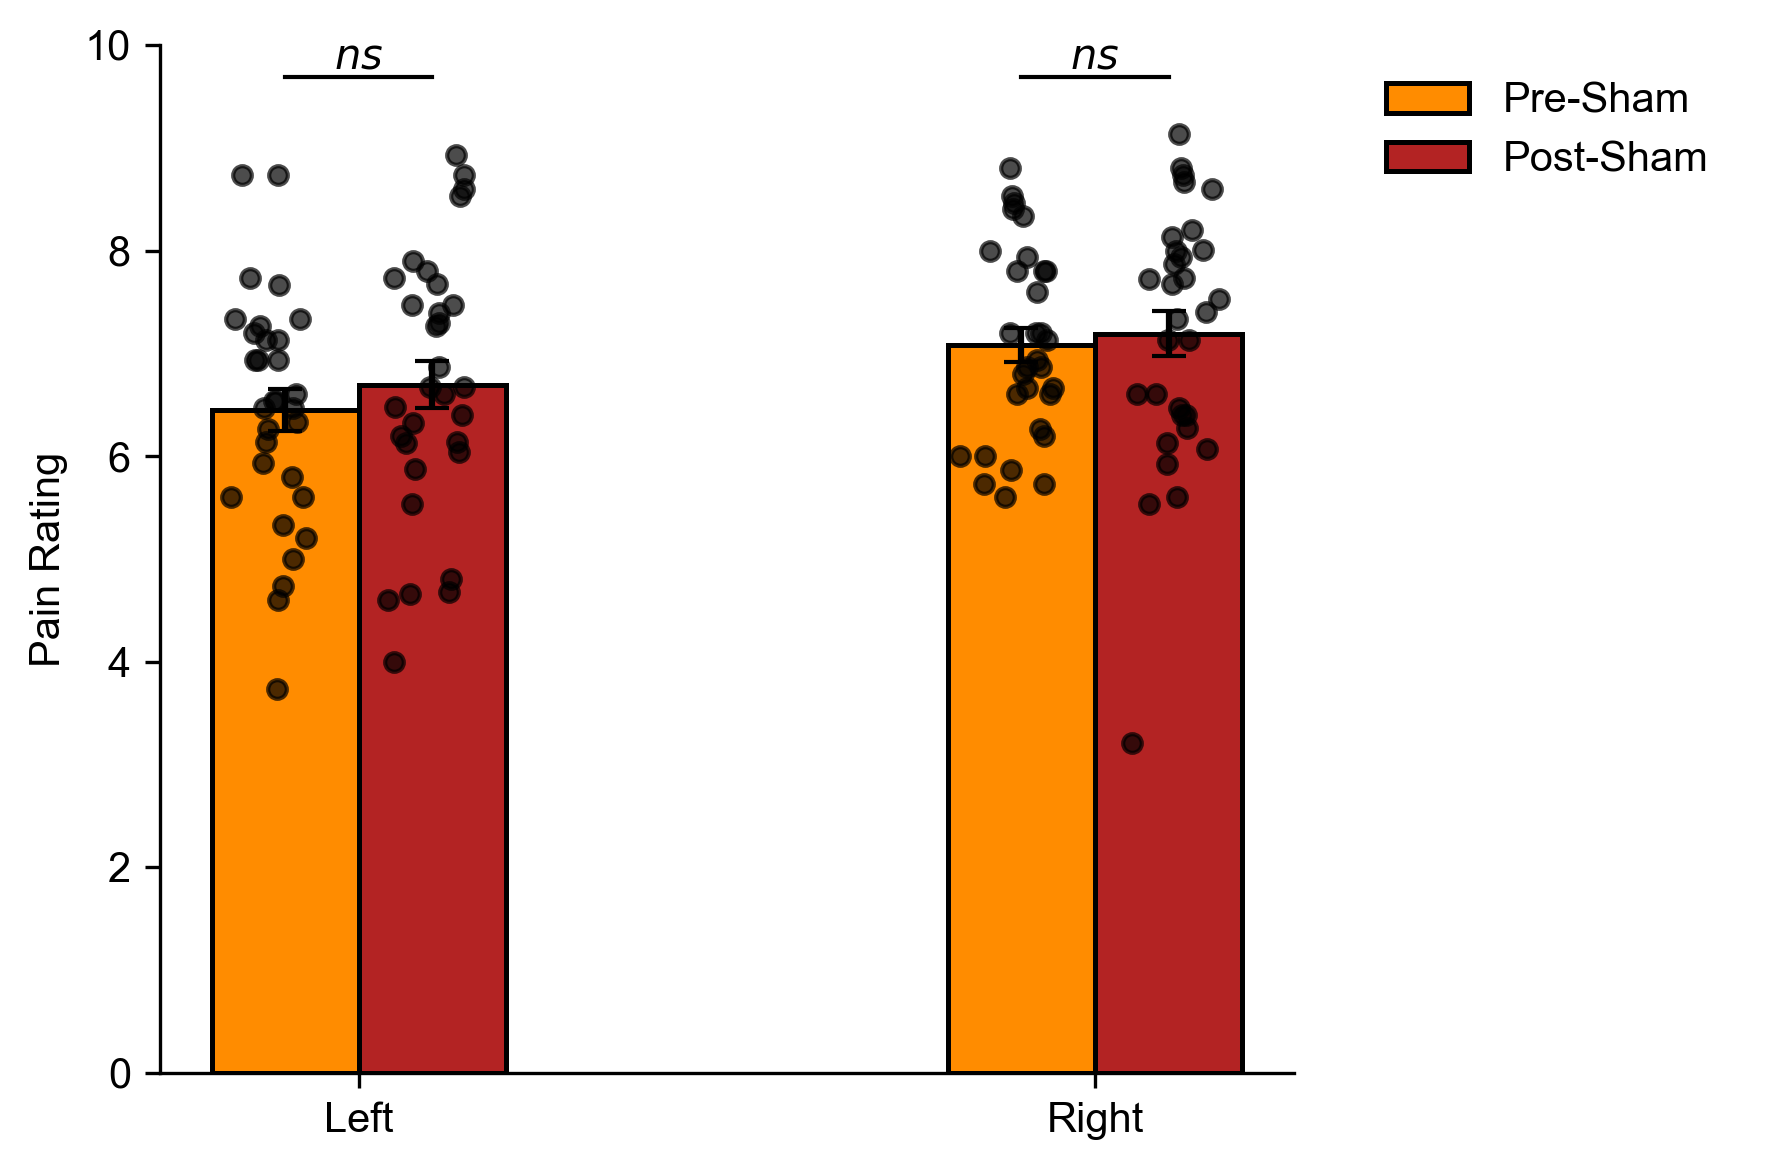

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- 假设已有以下数组，分别为各条件下的原始数据 ---
# con_left_pre, con_right_pre, con_left_post, con_right_post

# --- 计算均值与误差 ---
categories = ['Left', 'Right']
n_left = len(xi)
n_right = len(yi)

# 计算 Pre-Tens (Low) 条件下的均值
low = [
    xi.mean(),   # Left, Pre-Tens
    yi.mean()   # Right, Pre-Tens
]
# 计算 Post-Tens (High) 条件下的均值
high = [
    zi.mean(),  # Left, Post-Tens
    wi.mean()  # Right, Post-Tens
]

# 计算标准误
low_err = [
    xi.std() / np.sqrt(n_left),
    yi.std() / np.sqrt(n_right)
]
high_err = [
    zi.std() / np.sqrt(n_left),   # 假定 con_left_post 与 con_left_pre 样本量相同
    wi.std() / np.sqrt(n_right)  # 假定 con_right_post 与 con_right_pre 样本量相同
]

x = np.arange(len(categories))  # [0, 1]
width = 0.2  # 每根柱子的宽度

# --- 绘图 ---
# fig, ax = plt.subplots(figsize=(4, 3))
fig, (ax, ax_legend) = plt.subplots(
    1,
    2,
    figsize=(6, 4),
    gridspec_kw={'width_ratios': [4, 1]}
)


# 绘制 Pre-Tens (Low) 和 Post-Tens (High) 两组柱子，并且给每根柱子设置 edgecolor='black' 以画出黑色轮廓
bars_low = ax.bar(
    x - width/2,      # 在类别中心左移 width/2 来绘制 Pre-Tens
    low,
    width,
    yerr=low_err,        # Pre-Tens 对应的误差线
    label='Pre-Sham',
    color='#ff8c00',
    edgecolor='black',
    linewidth=1.2,
    capsize=4
)
bars_high = ax.bar(
    x + width/2,      # 在类别中心右移 width/2 来绘制 Post-Tens 
    high,
    width,
    yerr=high_err,       # Post-Tens 对应的误差线
    label='Post-Sham',
    color='#b32323',
    edgecolor='black',
    linewidth=1.2,
    capsize=4
)

# 设置坐标轴和刻度
ax.set_ylabel('Pain Rating')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 10)  # 保持与原图类似的纵轴范围 '#ff8c00','#b32323',

# --- 添加散点（原始数据分布） ---
# 为了让散点在 x 方向上稍作抖动以避免重叠，使用 np.random.normal 生成小幅度抖动
jitter_scale = 0.03

# Left 组：Pre-Tens (con_left_pre) 和 Post-Tens (con_left_post)
x_left_pre = x[0] - width/2
x_left_post = x[0] + width/2
# 在 x= x_left_pre 处绘制 con_left_pre 的散点
ax.scatter(
    x_left_pre + np.random.normal(loc=0, scale=jitter_scale, size=len(xi)),
    xi,
    color='black',
    alpha=0.7,
    s=20,
    label=None
)
# 在 x= x_left_post 处绘制 con_left_post 的散点
ax.scatter(
    x_left_post + np.random.normal(loc=0, scale=jitter_scale, size=len(zi)),
    zi,
    color='black',
    alpha=0.7,
    s=20,
    label=None
)

# Right 组：Pre-Tens (con_right_pre) 和 Post-Tens (con_right_post)
x_right_pre = x[1] - width/2
x_right_post = x[1] + width/2
# 在 x= x_right_pre 处绘制 con_right_pre 的散点
ax.scatter(
    x_right_pre + np.random.normal(loc=0, scale=jitter_scale, size=len(yi)),
    yi,
    color='black',
    alpha=0.7,
    s=20,
    label=None
)
# 在 x= x_right_post 处绘制 con_right_post 的散点
ax.scatter(
    x_right_post + np.random.normal(loc=0, scale=jitter_scale, size=len(wi)),
    wi,
    color='black',
    alpha=0.7,
    s=20,
    label=None
)

# --- 添加显著性标注 *** （Pre vs Post） ---
# Left 组：
y_u = max(low[0], high[0]) + 3  # 根据最大值适当抬高标注位置
ax.plot([x_left_pre, x_left_post], [y_u, y_u], color='black', linewidth=1)
ax.text((x_left_pre + x_left_post) / 2, y_u, r"$ns$", ha='center', va='bottom')

# Right 组：
y_l = y_u
ax.plot([x_right_pre, x_right_post], [y_l, y_l], color='black', linewidth=1)
ax.text((x_right_pre + x_right_post) / 2, y_l, r"$ns$", ha='center', va='bottom')

# --- （可选）在两组 Post-Tens 之间添加比较标注，如果需要则取消注释以下代码 ---
# y_bracket = max(high) + 3.0
# x_left = x_left_post
# x_right = x_right_post
# # 横线
# ax.plot([x_left, x_right], [y_bracket, y_bracket], color='black', linewidth=1)
# # 左竖线
# ax.plot([x_left, x_left], [y_bracket, y_bracket - 0.5], color='black', linewidth=1)
# # 右竖线
# ax.plot([x_right, x_right], [y_bracket, y_bracket - 0.5], color='black', linewidth=1)
# ax.text((x_left + x_right) / 2, y_bracket + 0.2, '(ns)', ha='center', va='bottom')

# 添加图例
# ax.legend(title='Somatic Pain')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# --- 右侧子图：只放置图例，并关闭坐标轴显示 ---
ax_legend.axis('off')

# 从左侧子图中获取 legend 句柄和标签
handles, labels = ax.get_legend_handles_labels()

# 在右侧子图中绘制 Legend
legend = ax_legend.legend(
    handles=handles,
    labels=labels,
    # title='Order',
    # title_fontsize='12',
    # loc='center',
    bbox_to_anchor=(1.02, 1.00),
    frameon=False  # 关闭边框
)
legend.get_frame().set_facecolor('white')  # 背景设为白色

plt.tight_layout()
# save fig
plt.show()


# TENS ANOVA

In [6]:
import pandas as pd
xi = tens_behav_tens_pre_left
yi = tens_behav_tens_pre_right
zi = tens_behav_tens_post_left
wi = tens_behav_tens_post_right
# 假设四个数组长度相同
n = len(xi)
assert len(yi)  == n
assert len(zi)  == n
assert len(wi) == n

# 生成被试 ID（可从 1 到 n，也可用 0 到 n-1 都行）
subjects = np.arange(1, n+1)

# 对于每个被试，需要创建 4 条记录：left-pre, right-pre, left-post, right-post
# 我们把它们拼接起来，形成一个一维向量
values = np.concatenate([
    xi,    # 对应 left × pre
    yi,   # 对应 right × pre
    zi,   # 对应 left × post
    wi   # 对应 right × post
])

# 对应的 condition 标记
condition = (['left']  * n) + (['right'] * n) + (['left']  * n) + (['right'] * n)

# 对应的 time 标记
time = (['pre']  * n) + (['pre']  * n) + (['post'] * n) + (['post'] * n)

# 对应的 subject 标记：每个被试在四个记录中都要出现
subject = list(subjects) * 4

# 构建 DataFrame
df = pd.DataFrame({
    'subject': subject,
    'condition': condition,
    'time': time,
    'value': values
})

import pingouin as pg

# 这里假设 df 已经如上构建：
# df.columns = ['subject', 'condition', 'time', 'value']

aov = pg.rm_anova(
    dv='value',                # 因变量列名
    within=['condition', 'time'], # 两个组内因子
    subject='subject',         # 被试 ID 列
    data=df,
    detailed=True              # 输出更详细结果（包括各效应的 η²、校正信息等）
)
print(aov)

             Source         SS  ddof1  ddof2         MS          F  \
0         condition  73.082305      1     29  73.082305  92.816565   
1              time  35.670688      1     29  35.670688  31.628846   
2  condition * time  36.425823      1     29  36.425823  38.795240   

          p-unc     p-GG-corr       ng2  eps  
0  1.526821e-10  1.526821e-10  0.293515  1.0  
1  4.489071e-06  4.489071e-06  0.168593  1.0  
2  8.524137e-07  8.524137e-07  0.171550  1.0  


/home/lxm/anaconda3/envs/test/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/home/lxm/anaconda3/envs/test/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)


In [7]:
posthoc = pg.pairwise_ttests(
    dv='value',
    within=['condition', 'time'],
    subject='subject',
    data=df,
    padjust='bonf'   # Bonferroni 校正
)

posthoc

/home/lxm/anaconda3/envs/test/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,condition,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,condition,-,left,right,True,True,-9.634135,29.0,two-sided,1.526821e-10,NaN,NaN,6.706e+07,-1.540703
1,time,-,post,pre,True,True,-5.623953,29.0,two-sided,4.489071e-06,NaN,NaN,4407.503,-1.033307
2,condition * time,left,post,pre,True,True,-6.739533,29.0,two-sided,2.142032e-07,4.284065e-07,bonf,7.381e+04,-1.601611
3,condition * time,right,post,pre,True,True,0.064219,29.0,two-sided,9.492368e-01,1.000000e+00,bonf,0.195,0.010313


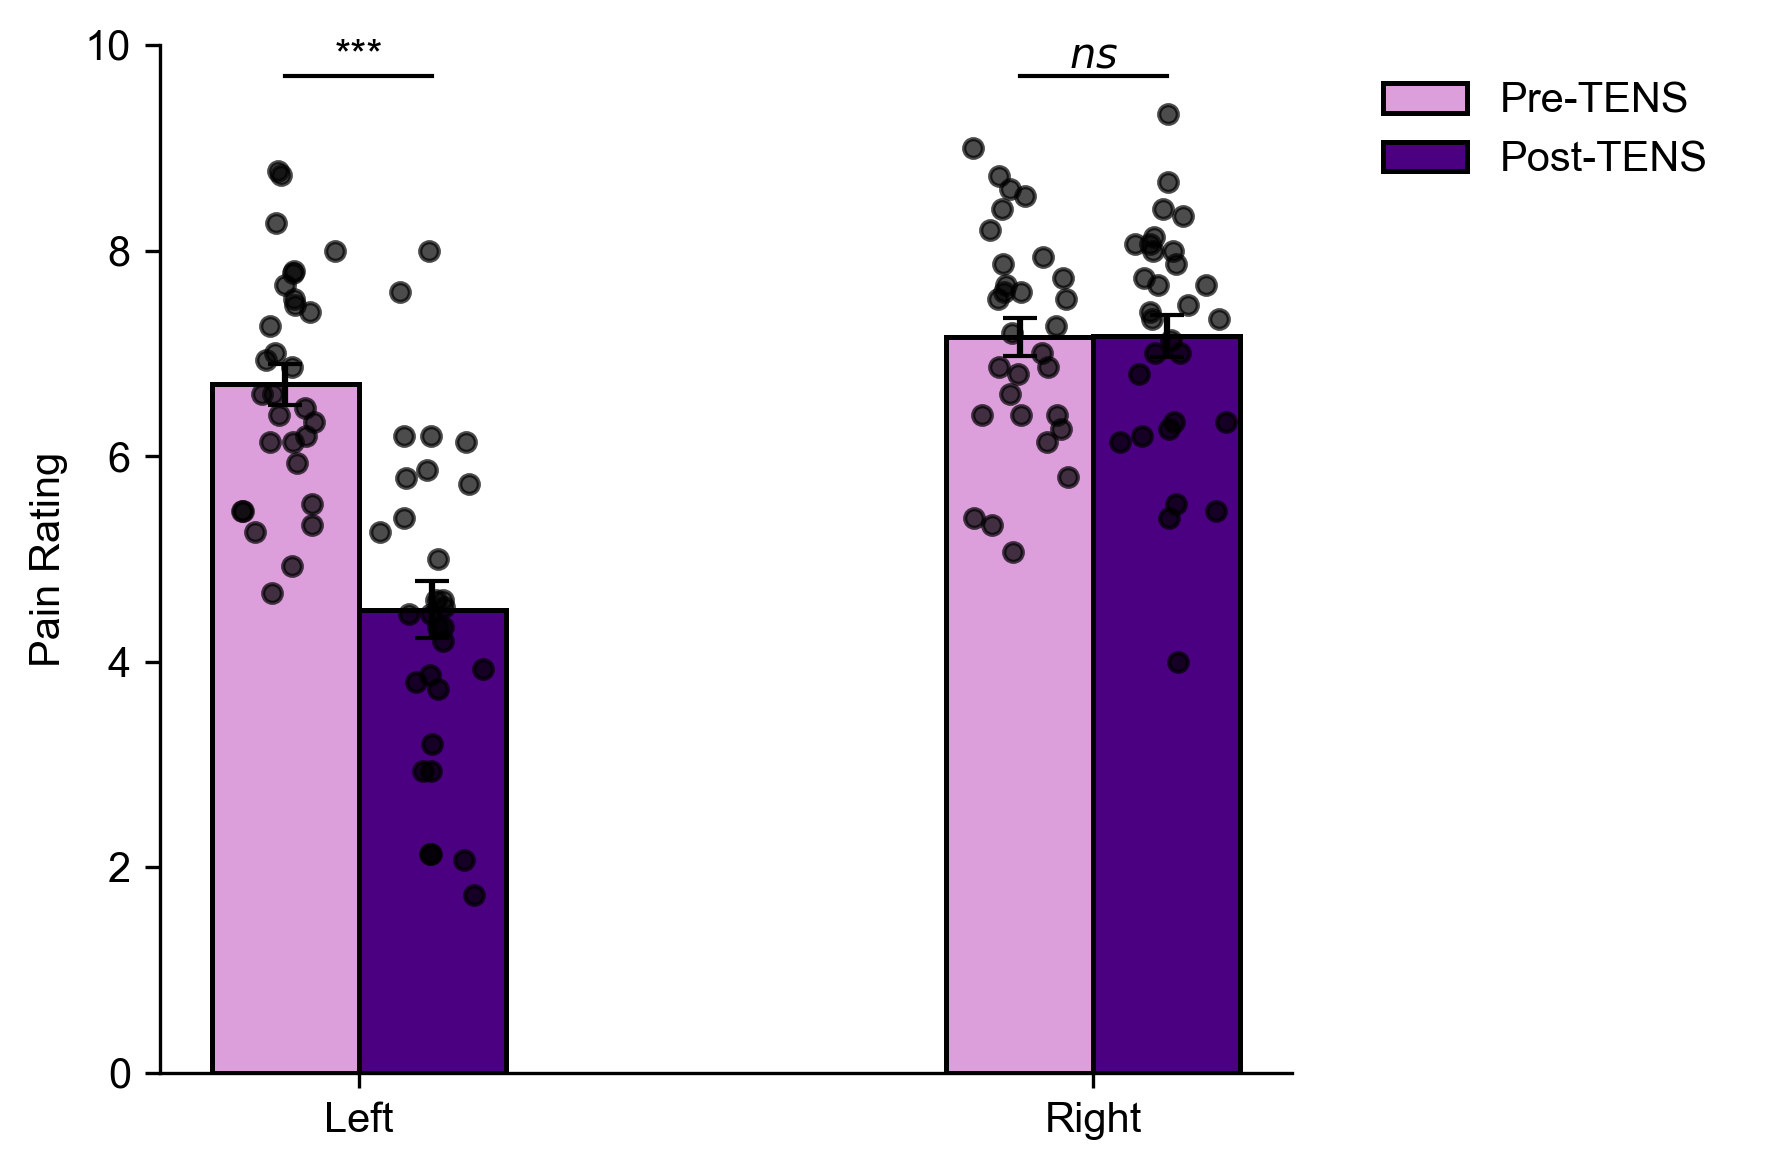

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --- 假设已有以下数组，分别为各条件下的原始数据 ---
# con_left_pre, con_right_pre, con_left_post, con_right_post

# --- 计算均值与误差 ---
categories = ['Left', 'Right']
n_left = len(xi)
n_right = len(yi)

# 计算 Pre-Tens (Low) 条件下的均值
low = [
    xi.mean(),   # Left, Pre-Tens
    yi.mean()   # Right, Pre-Tens
]
# 计算 Post-Tens (High) 条件下的均值
high = [
    zi.mean(),  # Left, Post-Tens
    wi.mean()  # Right, Post-Tens
]

# 计算标准误
low_err = [
    xi.std() / np.sqrt(n_left),
    yi.std() / np.sqrt(n_right)
]
high_err = [
    zi.std() / np.sqrt(n_left),   # 假定 con_left_post 与 con_left_pre 样本量相同
    wi.std() / np.sqrt(n_right)  # 假定 con_right_post 与 con_right_pre 样本量相同
]

x = np.arange(len(categories))  # [0, 1]
width = 0.2  # 每根柱子的宽度

# --- 绘图 ---
# fig, ax = plt.subplots(figsize=(4, 3))
fig, (ax, ax_legend) = plt.subplots(
    1,
    2,
    figsize=(6, 4),
    gridspec_kw={'width_ratios': [4, 1]}
)


# 绘制 Pre-Tens (Low) 和 Post-Tens (High) 两组柱子，并且给每根柱子设置 edgecolor='black' 以画出黑色轮廓
bars_low = ax.bar(
    x - width/2,      # 在类别中心左移 width/2 来绘制 Pre-Tens
    low,
    width,
    yerr=low_err,        # Pre-Tens 对应的误差线
    label='Pre-TENS',
    color='#dc9fdc',
    edgecolor='black',
    linewidth=1.2,
    capsize=4
)
bars_high = ax.bar(
    x + width/2,      # 在类别中心右移 width/2 来绘制 Post-Tens
    high,
    width,
    yerr=high_err,       # Post-Tens 对应的误差线
    label='Post-TENS',
    color='#4b0082',
    edgecolor='black',
    linewidth=1.2,
    capsize=4
)

# 设置坐标轴和刻度
ax.set_ylabel('Pain Rating')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 10)  # 保持与原图类似的纵轴范围 '#ff8c00','#b32323',

# --- 添加散点（原始数据分布） ---
# 为了让散点在 x 方向上稍作抖动以避免重叠，使用 np.random.normal 生成小幅度抖动
jitter_scale = 0.03

# Left 组：Pre-Tens (con_left_pre) 和 Post-Tens (con_left_post)
x_left_pre = x[0] - width/2
x_left_post = x[0] + width/2
# 在 x= x_left_pre 处绘制 con_left_pre 的散点
ax.scatter(
    x_left_pre + np.random.normal(loc=0, scale=jitter_scale, size=len(xi)),
    xi,
    color='black',
    alpha=0.7,
    s=20,
    label=None
)
# 在 x= x_left_post 处绘制 con_left_post 的散点
ax.scatter(
    x_left_post + np.random.normal(loc=0, scale=jitter_scale, size=len(zi)),
    zi,
    color='black',
    alpha=0.7,
    s=20,
    label=None
)

# Right 组：Pre-Tens (con_right_pre) 和 Post-Tens (con_right_post)
x_right_pre = x[1] - width/2
x_right_post = x[1] + width/2
# 在 x= x_right_pre 处绘制 con_right_pre 的散点
ax.scatter(
    x_right_pre + np.random.normal(loc=0, scale=jitter_scale, size=len(yi)),
    yi,
    color='black',
    alpha=0.7,
    s=20,
    label=None
)
# 在 x= x_right_post 处绘制 con_right_post 的散点
ax.scatter(
    x_right_post + np.random.normal(loc=0, scale=jitter_scale, size=len(wi)),
    wi,
    color='black',
    alpha=0.7,
    s=20,
    label=None
)

# --- 添加显著性标注 *** （Pre vs Post） ---
# Left 组：
y_u = max(low[0], high[0]) + 3  # 根据最大值适当抬高标注位置
ax.plot([x_left_pre, x_left_post], [y_u, y_u], color='black', linewidth=1)
ax.text((x_left_pre + x_left_post) / 2, y_u, "***", ha='center', va='bottom')

# Right 组：
y_l = y_u
ax.plot([x_right_pre, x_right_post], [y_l, y_l], color='black', linewidth=1)
ax.text((x_right_pre + x_right_post) / 2, y_l, r"$ns$", ha='center', va='bottom')

# --- （可选）在两组 Post-Tens 之间添加比较标注，如果需要则取消注释以下代码 ---
# y_bracket = max(high) + 3.0
# x_left = x_left_post
# x_right = x_right_post
# # 横线
# ax.plot([x_left, x_right], [y_bracket, y_bracket], color='black', linewidth=1)
# # 左竖线
# ax.plot([x_left, x_left], [y_bracket, y_bracket - 0.5], color='black', linewidth=1)
# # 右竖线
# ax.plot([x_right, x_right], [y_bracket, y_bracket - 0.5], color='black', linewidth=1)
# ax.text((x_left + x_right) / 2, y_bracket + 0.2, '(ns)', ha='center', va='bottom')

# 添加图例
# ax.legend(title='Somatic Pain')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# --- 右侧子图：只放置图例，并关闭坐标轴显示 ---
ax_legend.axis('off')

# 从左侧子图中获取 legend 句柄和标签
handles, labels = ax.get_legend_handles_labels()

# 在右侧子图中绘制 Legend
legend = ax_legend.legend(
    handles=handles,
    labels=labels,
    # title='Order',
    # title_fontsize='12',
    # loc='center',
    bbox_to_anchor=(1.02, 1.00),
    frameon=False  # 关闭边框
)
legend.get_frame().set_facecolor('white')  # 背景设为白色

plt.tight_layout()
# save fig
plt.show()


# IMG

In [9]:
lassopcr = joblib.load('0data/lassopcr.pkl')

In [12]:
sham_pre_left_pred = lassopcr.predict(tens_img_sham_pre_left)
sham_pre_right_pred = lassopcr.predict(tens_img_sham_pre_right)
sham_post_left_pred = lassopcr.predict(tens_img_sham_post_left)
sham_post_right_pred = lassopcr.predict(tens_img_sham_post_right)
tens_pre_left_pred = lassopcr.predict(tens_img_tens_pre_left)
tens_pre_right_pred = lassopcr.predict(tens_img_tens_pre_right)
tens_post_left_pred = lassopcr.predict(tens_img_tens_post_left)
tens_post_right_pred = lassopcr.predict(tens_img_tens_post_right)

In [13]:
print(pearsonr(sham_pre_left_pred - sham_post_left_pred, tens_behav_sham_pre_left- tens_behav_sham_post_left))
print(pearsonr(sham_pre_right_pred - sham_post_right_pred, tens_behav_sham_pre_right- tens_behav_sham_post_right))
print(pearsonr(tens_pre_left_pred - tens_post_left_pred, tens_behav_tens_pre_left- tens_behav_tens_post_left))
print(pearsonr(tens_pre_right_pred - tens_post_right_pred, tens_behav_tens_pre_right- tens_behav_tens_post_right))

PearsonRResult(statistic=np.float64(0.13271947399083076), pvalue=np.float64(0.4766243829287243))
PearsonRResult(statistic=np.float64(-0.04077956423785549), pvalue=np.float64(0.8275764509841789))
PearsonRResult(statistic=np.float64(0.36182324852552455), pvalue=np.float64(0.04944635100137572))
PearsonRResult(statistic=np.float64(0.1425265587120675), pvalue=np.float64(0.4524556723389751))
